In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from models import read_data, common, supervised_models, time_series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix

# 1. DATA

## 1.1. Common Data for Time Series and Classification

In [3]:
read_data.read_data_common?

Signature: read_data.read_data_common(path_file)
Docstring:
Read Earthquake file and return 2 dataframes.
:param path_file: path and file name to be read
:return: sismos  and all_months dataframes

sismos = ['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place',
          'time', 'year', 'month', 'YM', 'magtype', 'mag_int', 'region' ]

all_months = list of all months from  January 1970 to June 2019
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [4]:
sismos, all_months = read_data.read_data_common('./data/earthquake.csv')

Information related to earthquakes from 1970 until nowdays

In [5]:
sismos.head(2)

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,mag_int,region
1309,iscgem798065,1970-03-15,-29.701,-69.397,116.7,6.0,"San Juan, Argentina",1970-03-15 12:39:18+00:00,1970,3,1970-03-01,medium,6,Atacama
1308,iscgemsup794500,1970-06-11,-24.418,-68.413,110.6,6.6,"Antofagasta, Chile",1970-06-11 06:02:56+00:00,1970,6,1970-06-01,high,6,Atacama


In [6]:
sismos.describe()

,latitude,longitude,depth,mag,year,month,mag_int
count,46078.000000,46078.000000,46078.000000,46078.000000,46078.000000,46078.000000,46078.000000
mean,-30.390042,-70.558425,70.897992,3.931616,2002.317896,6.420005,3.485980
std,5.203371,1.833498,60.026517,0.746837,9.376788,3.393574,0.812799
min,-57.023400,-80.284600,0.000000,2.500000,1970.000000,1.000000,2.000000
25%,-33.579000,-71.756000,24.400000,3.400000,1998.000000,3.000000,3.000000
50%,-32.004100,-70.884000,45.800000,4.000000,2003.000000,6.000000,4.000000
75%,-27.808350,-69.481000,110.520000,4.400000,2008.000000,9.000000,4.000000
max,-17.979300,-64.878000,435.000000,8.800000,2019.000000,12.000000,8.000000


### Check null values

In [7]:
sismos.isnull().sum(axis = 0)

id           0
date         0
latitude     0
longitude    0
depth        0
mag          0
place        0
time         0
year         0
month        0
YM           0
magtype      0
mag_int      0
region       0
dtype: int64

In [8]:
sismos.isnull().values.any()

False

### Duplicates

There is no duplicates by id

In [9]:
sismos[sismos['id'].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,mag_int,region


In [10]:
sismos[sismos[['time', 'latitude', 'longitude','mag']].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,mag_int,region


### Plots
__The farther north the higher the frequency__

In [11]:
regions = ['Atacama', 'Santiago', 'Puerto Mont', 'Patagonia']

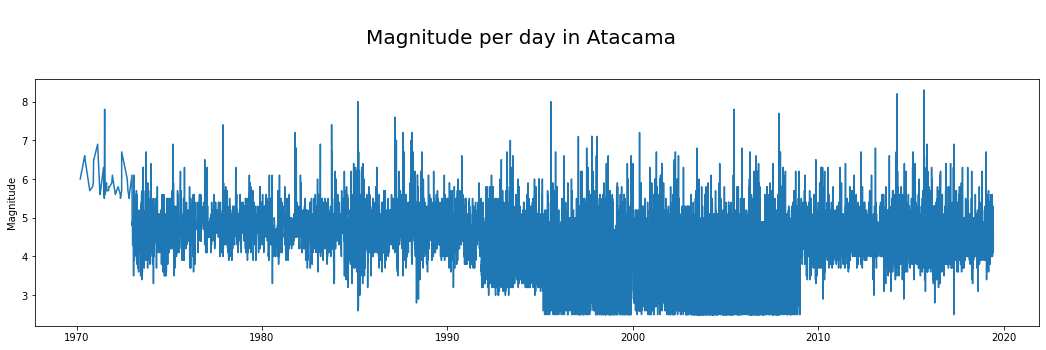

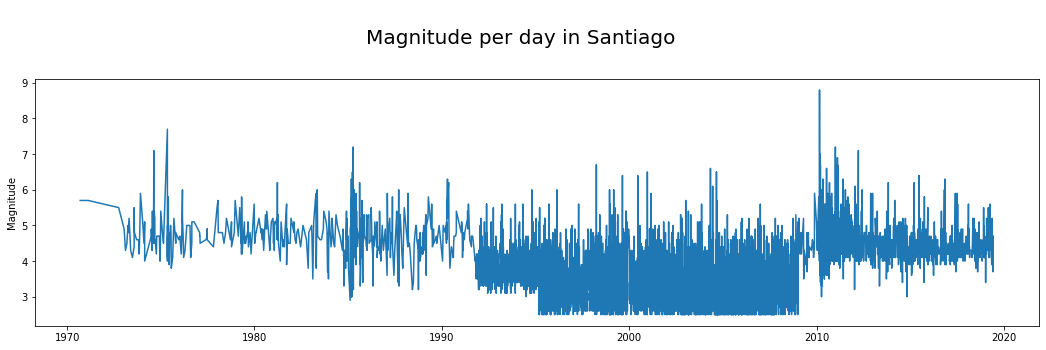

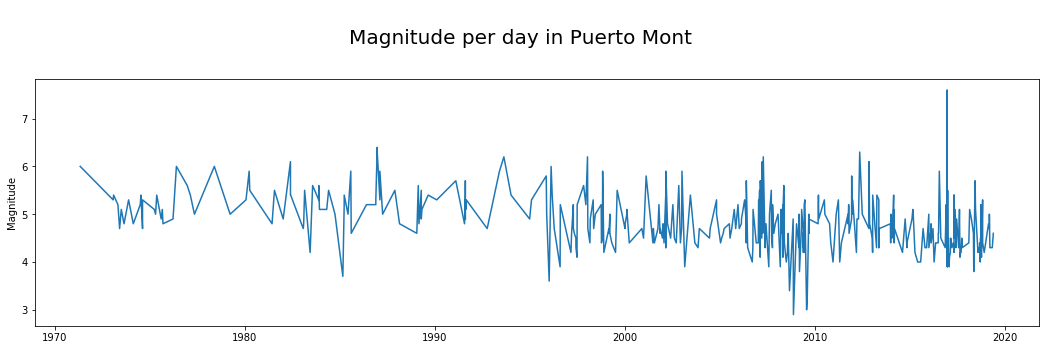

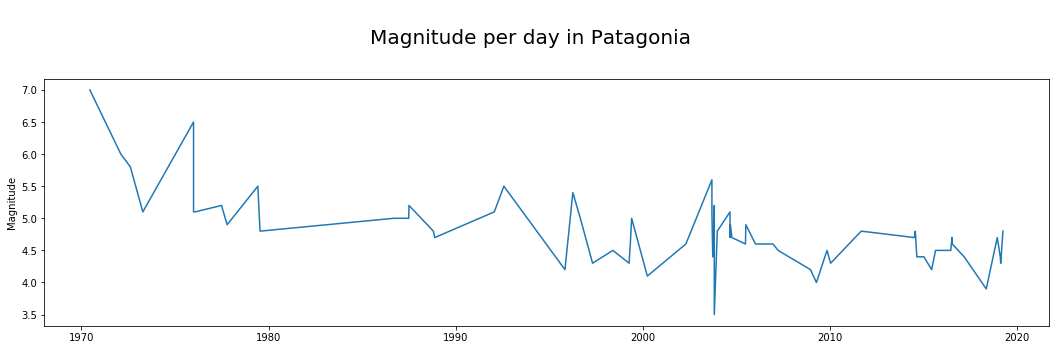

In [12]:
for i, region in enumerate(regions):
    dfaux = sismos[sismos['region']==region]
    common.plot(dfaux['date'], dfaux['mag'], 'Magnitude', '\nMagnitude per day in ' + region)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f5ff320>,
      dtype=object)

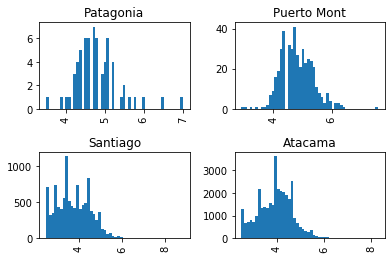

In [13]:
sismos[['mag','region']].hist(bins=50, by='region')

## 1.2. Time Series Data

In [14]:
read_data.read_data_time_series?

Signature: read_data.read_data_time_series(sismos, all_months)
Docstring:
Return required DataFrames for Time Series Analysis
:param sismos: ['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place',
                'time', 'year', 'month', 'YM', 'magtype', 'mag_int', 'region' ]
:param all_months: list of all months from  January 1970 to June 2019
:return: frequency_year, time_series_magnitude

frequency_year = frecuency of earthquakes per year and magnitude type where magtype is
                {low: mag in [0,4), medium: mag in [4,6), high: mag in [6,10)}
                        low --> you don't notice them
                        medium --> they are not scary
                        high --> the thing would get serious
                columns = ['year', 'magtype', 'magcount', 'magmax']

time_series_magnitude =  time series (frequency = month/yeam, data = maximum magnitude per period)
        
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.p

In [15]:
frequency_year, mag_ym = read_data.read_data_time_series(sismos, all_months)

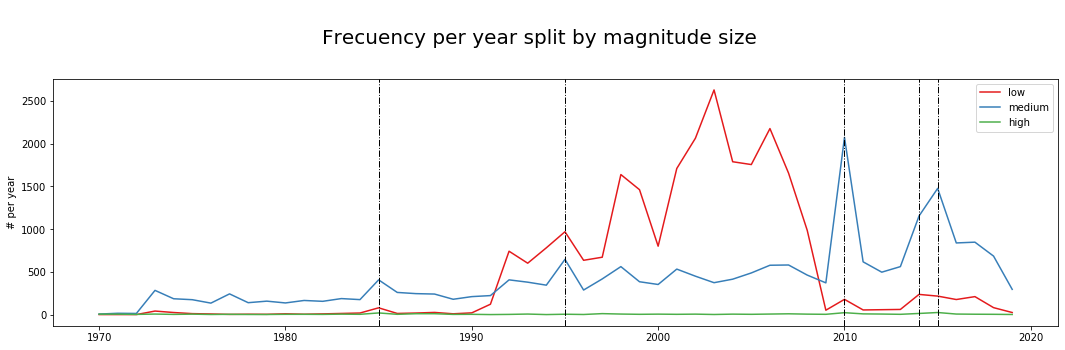

In [16]:
common.plot_time_series_with_big_earthquakes('\nFrecuency per year split by magnitude size', '# per year','year',
                                             frequency_year,
                                             'magcount','magtype',
                                             sismos[sismos['mag'] > 7.8])

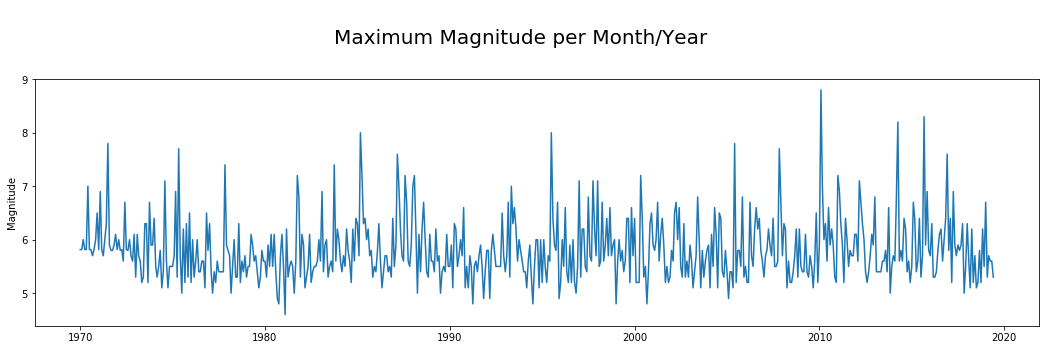

In [17]:
common.plot(mag_ym.index, mag_ym['mag'], 'Magnitude', '\nMaximum Magnitude per Month/Year')

## 1.3. Classification Data

In [18]:
read_data.read_data_classification?

Signature: read_data.read_data_classification(sismos, all_months, path_file)
Docstring:
Read Temperature file and return a Dataframe and a Series
:param sismos: ['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place',
                'time', 'year', 'month', 'YM', 'magtype', 'mag_int', 'region' ]
:param all_months: list of all months from  January 1970 to June 2019
:param path_file: path and name of temperature file
:return: features_classification and  label_classification

features_classification = ['YM', '2', '3', '4', '5', '6', '7', '8', 'Tempt', 'TemptUncert']
                        where YM reference to month/year
                        and '2', '3', '4', '5', '6', '7', '8' contain the number of earthquakes of that magnitude

label_classification = 1 if (next month has earthquakes > = 6) else is 0,
so if a know the earthquakes magnitudes and temperatures of the current month, then I can predict next month
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction

In [19]:
features_classification, label_classification = read_data.read_data_classification(sismos, all_months, 
                                                                                   './data/Temperature.csv')

In [20]:
features_classification.head(2)

,YM,2,3,4,5,6,7,8,Tempt,TemptUncert
0,1970-01-01,0,0,0,0,0,0,0,12.8,0.3
1,1970-02-01,0,0,0,0,0,0,0,12.0,0.4


In [21]:
label_classification[:3]

0    0
1    1
2    0
dtype: int64

In [22]:
title_figure = '\nFrecuency per month/year split by magnitude'
y_label = '# per month/year'
column_x='YM'
data_frame = features_classification
column_y = ''
column_lines = ['6','7','8']
data_frame_bar = sismos[sismos['mag'] >= 8]
big_earthquake = False

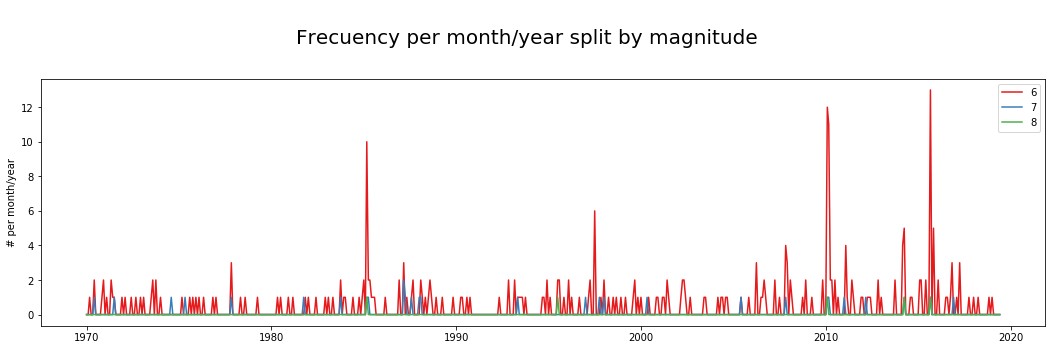

In [23]:
common.plot_regression_with_big_earthquake(title_figure,y_label,
                                           column_x,data_frame,
                                           column_y,column_lines,data_frame_bar,big_earthquake)

# 2. MODEL

## 2.1. Time Series
https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

Time Series is a series of data points measured at a constant interval which may be hourly, daily, weekly and so on. What makes time series different is that each data point in the series is dependent on the previous data points.

__BOX-JENKINS METHODOLOGY - SUMMARY__
1.  Plot Series
    * If variance is not constant (multiplicative model) $\rightarrow$ take logarithm to make it additive
2.  Stationary 
    * Differentiate 
    * Decompose and take random part
3.  Check it is stationary with Augmented Dickey-Fuller test
4.  Plot ACF and PACF to obtain p, q in ARMA(p,q)
5.  Select the most adequate model
6.  Forecast

In [24]:
my_time_series = time_series.TimeSeries(frequency_year, mag_ym)

### 1. Plot Rolling Statistics

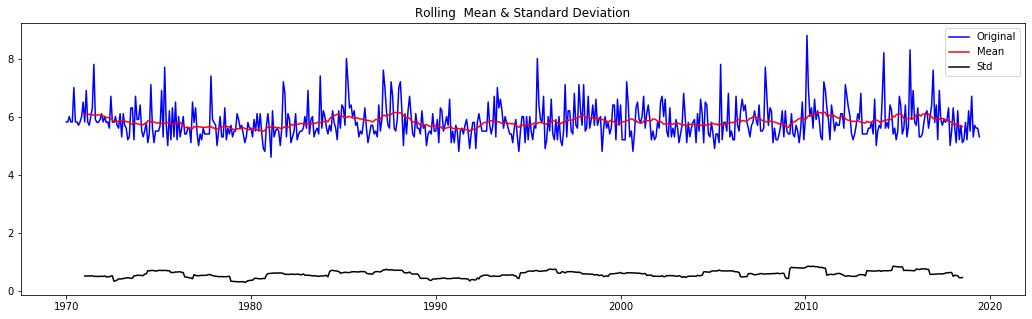

In [25]:
common.plot_rolling_stadistics(mag_ym)

Constant mean and standard variance, so Series is additive and stationary.

### 2. Stationary

How Does a Stationary Series look like?
* Constant Average
* Constant Variance
* Autocovariance does not depend on the time

How does a Non Stationary Series look like?
* Trend
* Seansonality

If it had not been stationary, we would have had to differentiate it as follows

```python
mag_diff = diff(mag_ym,k_diff=1)
```

Decompose time series

True

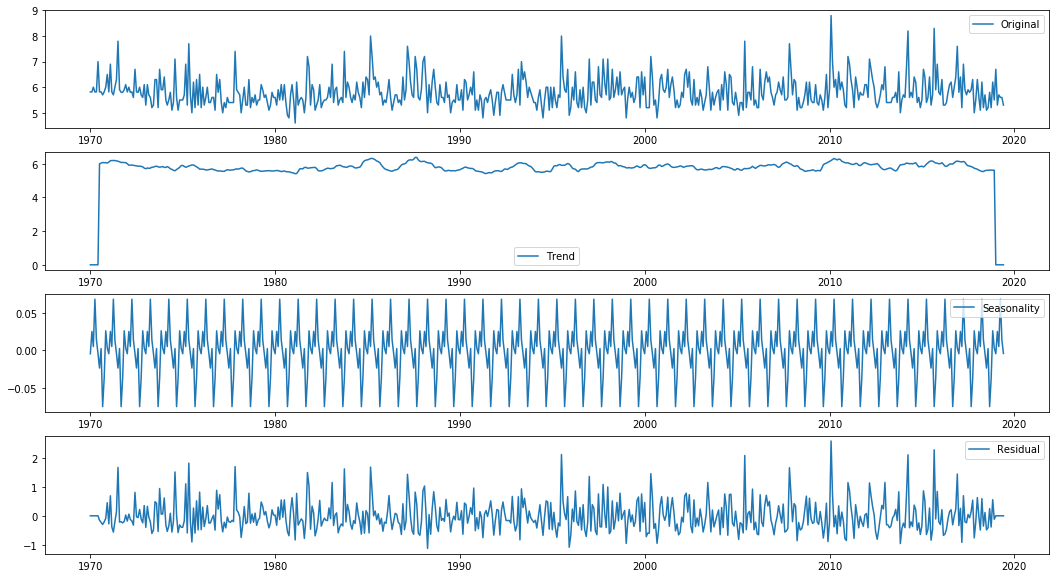

In [26]:
my_time_series.decomposition()

* There is no trend
* Seasonality per year
* Additive model

### 3. Dickey Fuller Test

`Null Hypothesis`: TS has a unit root and hence is non-stationary.
    
`Test Statistic`: The more negative, the more likely we are to reject the null hypothesis (we have a stationary dataset).

We reject the null (so it is stationary) if (p-value) is small

In [27]:
result_tst = my_time_series.dickey_fuller_test()
print(result_tst)

Dickey-Fuller Test: Magnitude per year 

ADF test statistic      -22.031536
p-value                   0.000000
# lags used               0.000000
# observations          593.000000
critical value (1%)      -3.441426
critical value (5%)      -2.866426
critical value (10%)     -2.569372

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 4. ACF / PACF
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

__ACF (AutoCorrelation Function)__: 
It measures the relation between Xt and Xt+n, including Xj for j=t+1,... t+n

For __MA(q)__: Xt = εt + b1εt-1 + b2εt-2 + ... + bqεt-q , __ACF(k)__ will be 0, k>q  $\rightarrow$  see at what lag it goes down to 0

For our dataset q could be 0 or 1

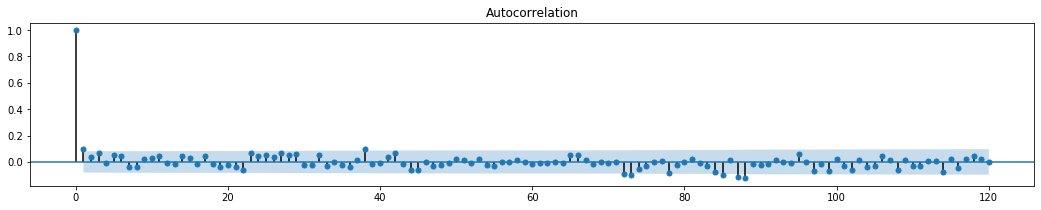

In [28]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_acf(mag_ym, lags = 120)
    plt.show();

__PACF (Partial Autocorrelation Function)__: measures the direct relation between Xt and Xt+n, excluding Xj for j=t+1,..., t+n-1

For __AR(p)__: Xt = a1Xt-1 + a2Xt-2 + ... + apXt-p + εt. __PACF(k)__ will be high for k=1,..., p, but will be 0 afterwards (by definition) $\rightarrow$ see at what lag it goes down to 0

For our dataset q could be 1 or 16

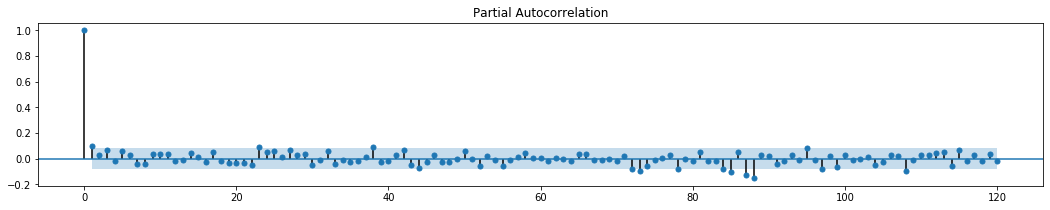

In [29]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_pacf(mag_ym, lags=120)
    plt.show();

### 5. Most Adequate Model

In [30]:
try:
    from pmdarima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima import auto_arima

__auto_arima__ returns best ARIMA model according to either AIC, AICc or BIC value. 

The function conducts a search over possible model within the order constraints provided.

* P: The order of the seasonal component for the auto-regressive (AR) model.
* D: The integration order of the seasonal process.
* Q: The order of the seasonal component of the moving average (MA) model

In [31]:
from pmdarima import auto_arima
# Stationary Dataset
auto_arima_model = auto_arima(mag_ym,seasonal=False,trace=True)

Fit ARIMA: order=(2, 0, 2); AIC=1051.143, BIC=1077.464, Fit time=0.259 seconds
Fit ARIMA: order=(0, 0, 0); AIC=1052.758, BIC=1061.532, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1049.106, BIC=1062.267, Fit time=0.015 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1049.353, BIC=1062.513, Fit time=0.018 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1050.749, BIC=1068.297, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1049.467, BIC=1067.014, Fit time=0.081 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1051.068, BIC=1073.002, Fit time=0.198 seconds
Total fit time: 0.607 seconds


In [32]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  594
Model:                     ARMA(1, 0)   Log Likelihood                -521.553
Method:                       css-mle   S.D. of innovations              0.582
Date:                Wed, 12 Jun 2019   AIC                           1049.106
Time:                        19:07:42   BIC                           1062.267
Sample:                             0   HQIC                          1054.231
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8154      0.026    219.790      0.000       5.764       5.867
ar.L1.y        0.0973      0.041      2.383      0.017       0.017       0.177
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.2778           +0.0000j           10.2778            0.0000
-----------------------------------------------------------------------------
"""

The best model is the one with smaller AIC, that is __ARMA(1, 1)__

__AIC (Akaike Information Criterion)__ manages a trade-off between the goodness of fit of the model and the complexity of the model. 

AIC does not provide a proof of a model (there is not a null hypothesis), so it can not say anything about the quality of the model in an absolute sense. If all the candidate models fit badly, AIC will not give any notice of it.

## 6. Forecast
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
https://www.alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html

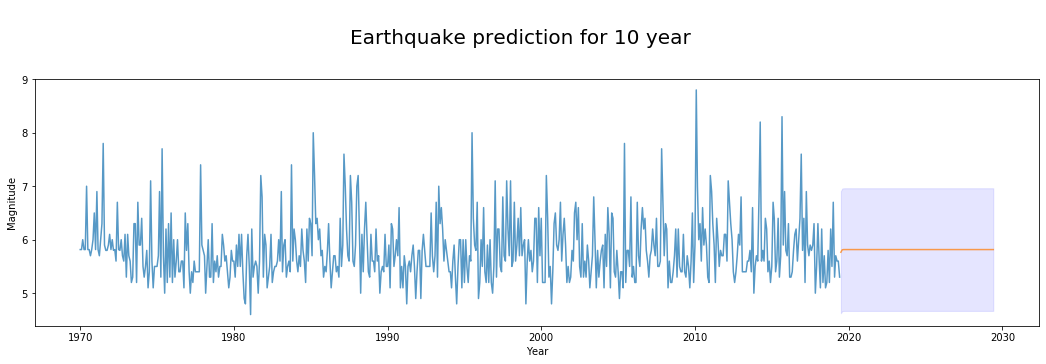

In [33]:
n_periods = 120
preds, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)
common.plot_time_series_prediction(n_periods,'\nEarthquake prediction for 10 year', 
                                   preds, conf_int , mag_ym)

As expected it is not a good prediction

## Autocorrelation plots
Autocorrelation plots are often used for checking randomness in time series. 
* If time series is random, such autocorrelations should be near zero for any and all time-lag separations. 
* If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

As you can see below, Earthquake are random, then why so much code? easy, to learn!

https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-autocorrelation

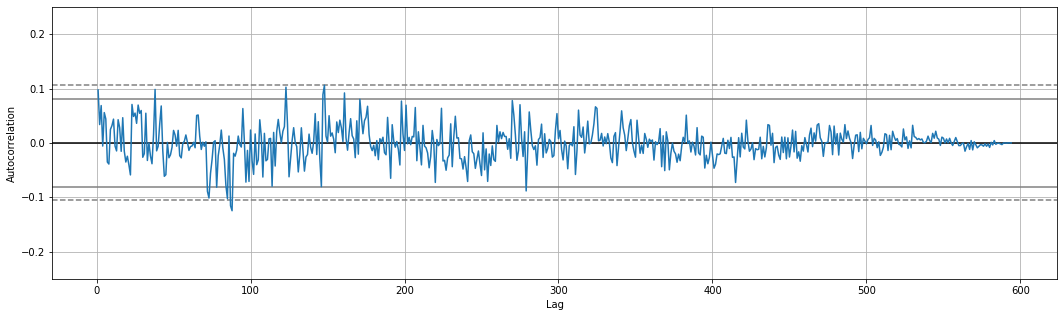

In [34]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(18,5))
ax1 = plt.subplot(111)
ax1.set_ylim([-0.25, 0.25])
autocorrelation_plot(mag_ym, ax1)
plt.show();

## 2.2. Time Series By Region

### Stacionary
time series in 4 regions are stacionaries




Dickey-Fuller Test: Magnitude per year 

ADF test statistic      -22.500582
p-value                   0.000000
# lags used               0.000000
# observations          593.000000
critical value (1%)      -3.441426
critical value (5%)      -2.866426
critical value (10%)     -2.569372

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Dickey-Fuller Test: Magnitude per year 

ADF test statistic     -7.708646e+00
p-value                 1.281345e-11
# lags used             4.000000e+00
# observations          5.890000e+02
critical value (1%)    -3.441501e+00
critical value (5%)    -2.866460e+00
critical value (10%)   -2.569390e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Dickey-Fuller Test: Magnitude per year 

ADF test statistic     -7.951112e+00
p-value                 3.124169e-12
# lags used             5.000000e+00
# observations          5.880000e

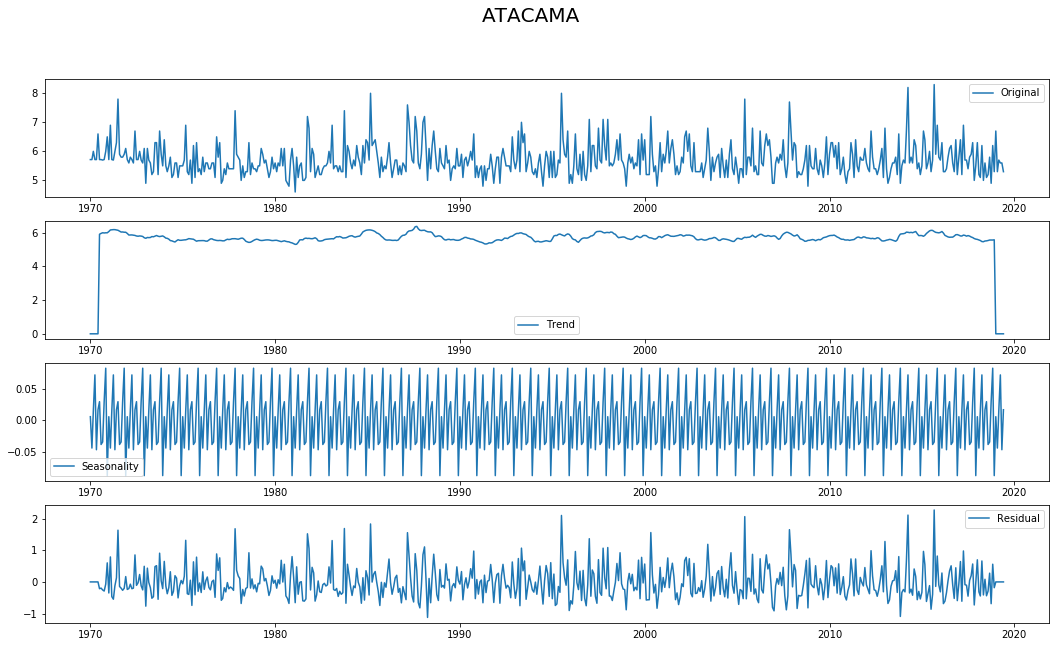

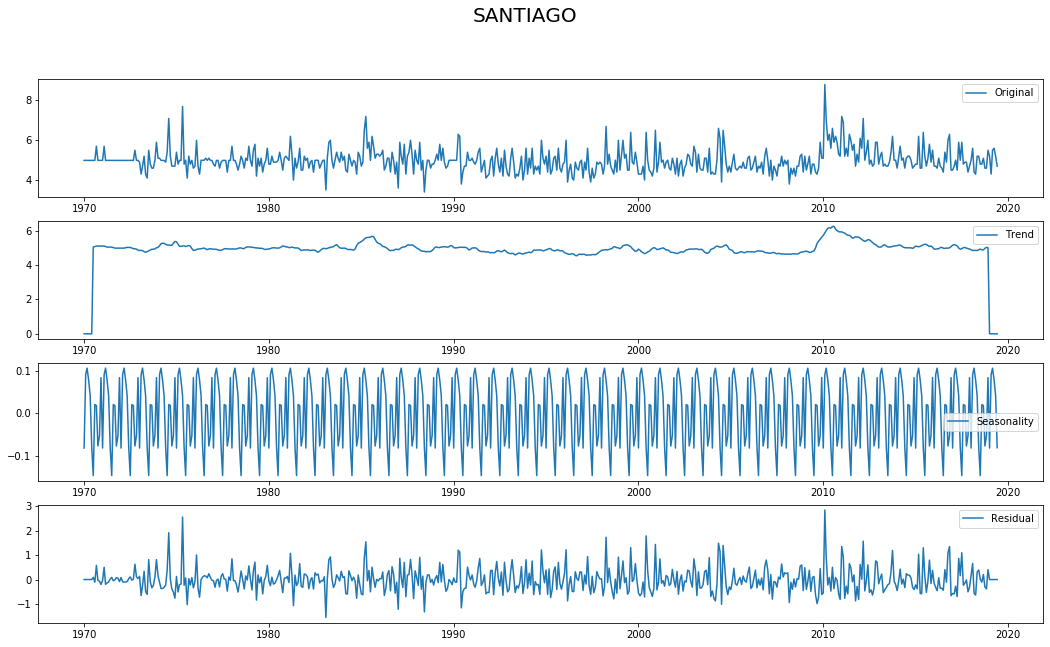

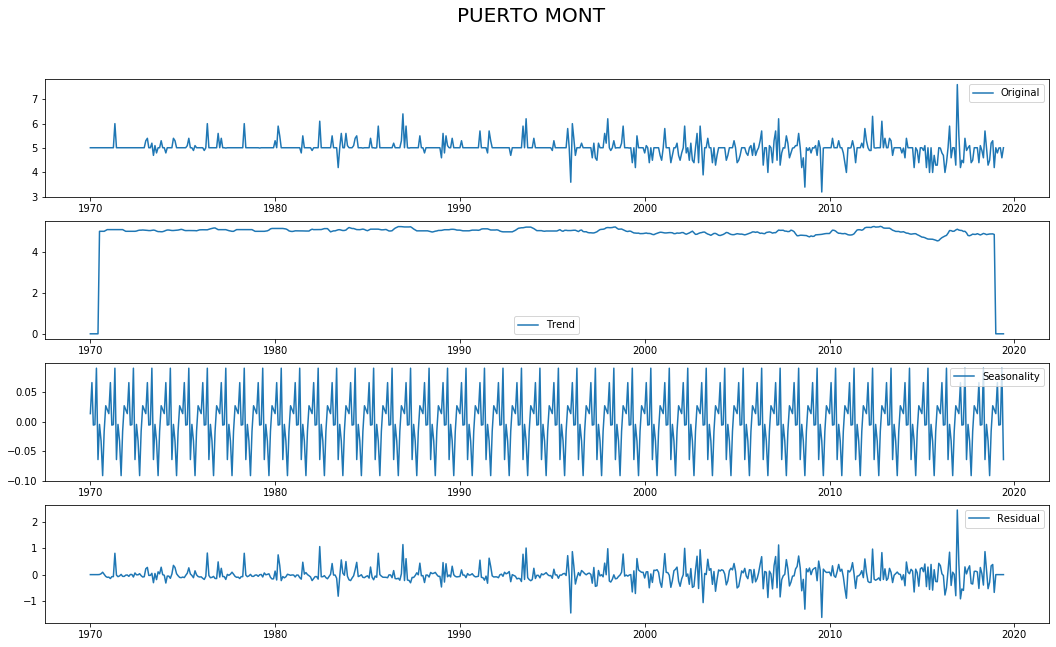

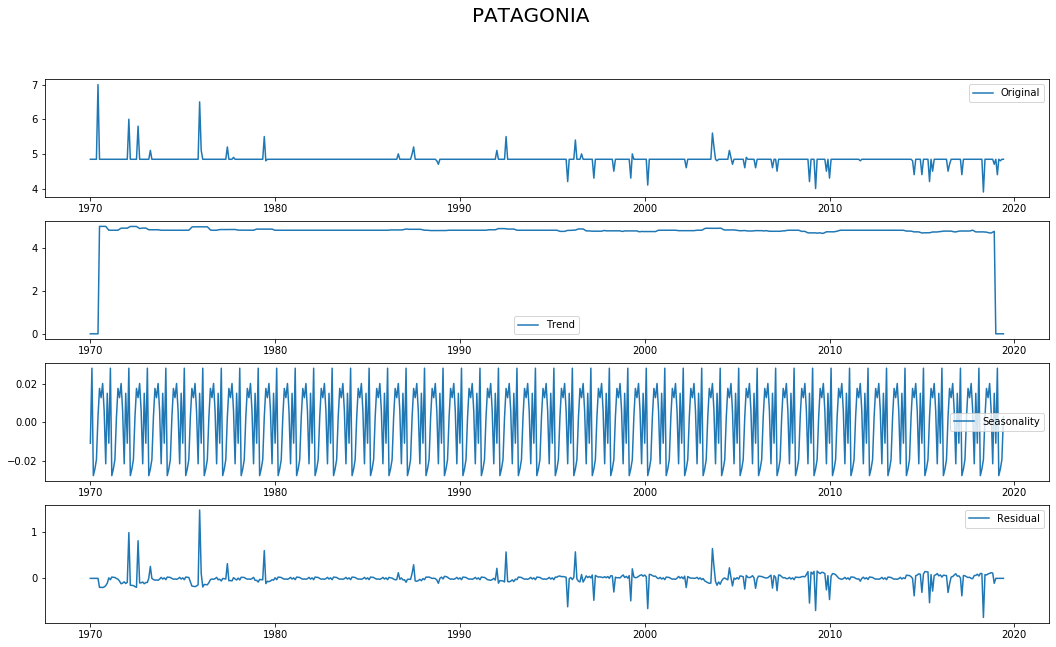

In [35]:
print('\n')
for region in regions:
    sismos_reg = sismos[sismos['region']==region]    
    frequency_year_region, mag_ym_region = read_data.read_data_time_series(sismos_reg, all_months)
    my_time_series_region = time_series.TimeSeries(frequency_year_region, mag_ym_region)
    result_tst = my_time_series_region.dickey_fuller_test()
    print('\n' + result_tst)
    my_time_series_region.decomposition(region.upper())


### Predict and prepare data for Tableau

In [36]:
tableau = sismos[['date', 'mag', 'region', 'latitude','longitude', 'depth']]
tableau.reset_index(inplace=True)
del tableau['index']
aux_tableau = pd.DataFrame()

Fit ARIMA: order=(2, 0, 2); AIC=1008.812, BIC=1035.133, Fit time=0.278 seconds
Fit ARIMA: order=(0, 0, 0); AIC=1007.501, BIC=1016.275, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1006.001, BIC=1019.161, Fit time=0.020 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1006.342, BIC=1019.503, Fit time=0.020 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1006.193, BIC=1023.740, Fit time=0.033 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1005.099, BIC=1022.647, Fit time=0.094 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1007.083, BIC=1029.017, Fit time=0.125 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.606 seconds
Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=1058.302, BIC=1067.075, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1036.938, BIC=1050.098, Fit time=0.024 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1039.175, BIC=1052.335, Fit time=0.022 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1036.889, BIC=

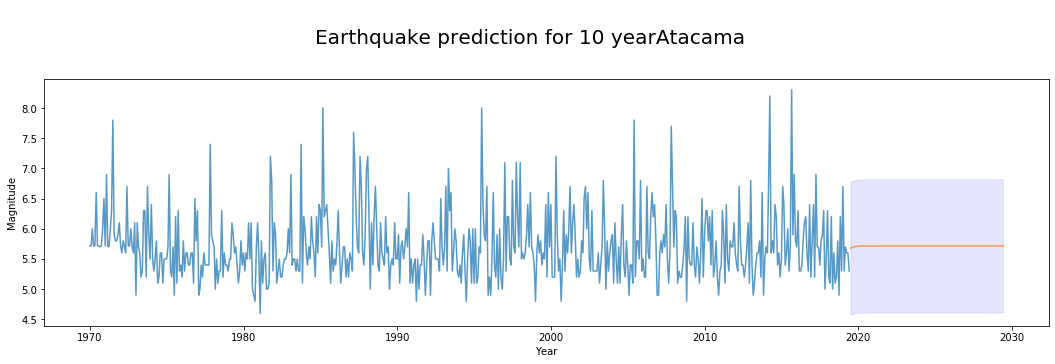

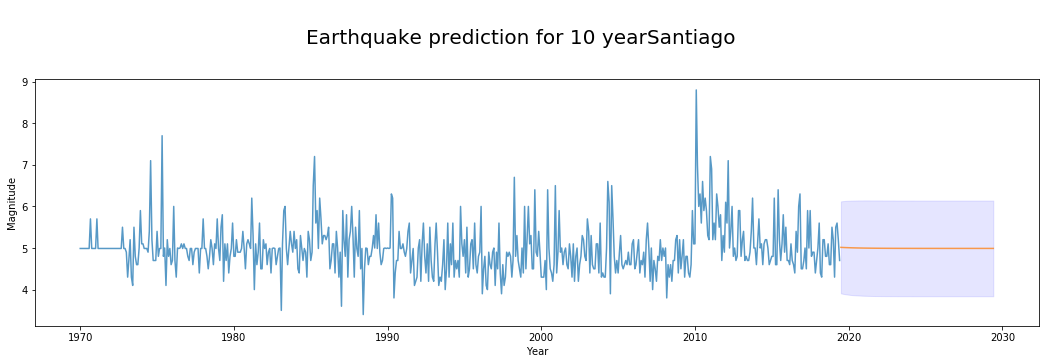

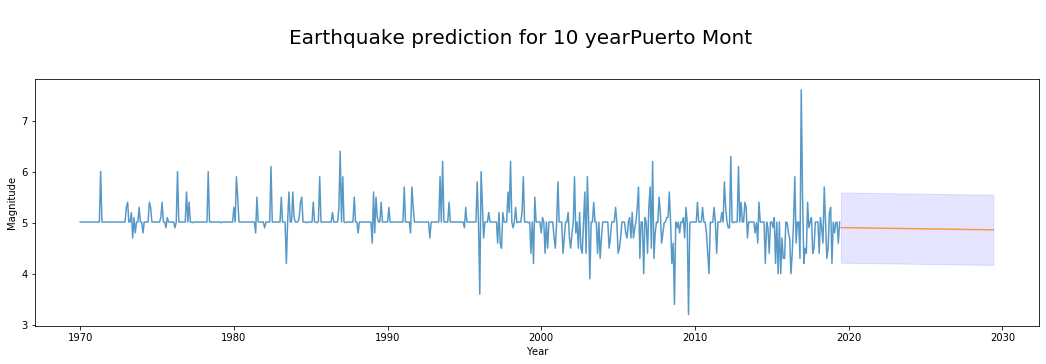

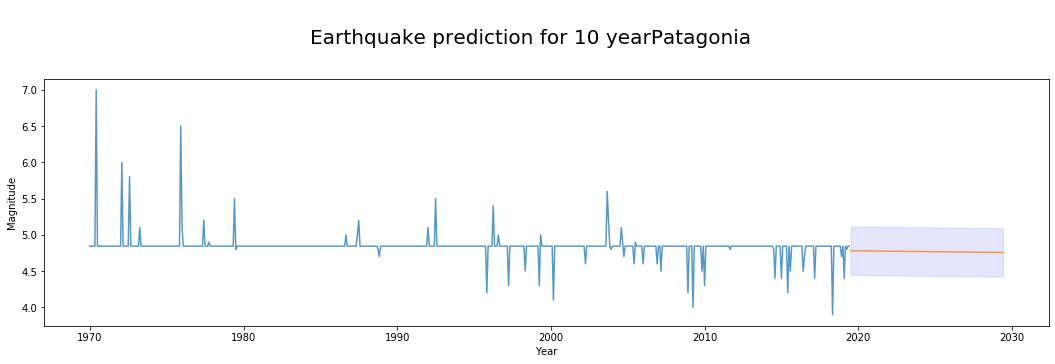

In [37]:
for region in regions:

    sismos_reg = sismos[sismos['region']==region]    
    frequency_year_region, mag_ym_region = read_data.read_data_time_series(sismos_reg, all_months)
    auto_arima_model = auto_arima(mag_ym_region,seasonal=False,trace=True,error_action="ignore")
    auto_arima_model.summary()
    preds, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)
    common.plot_time_series_prediction(120,'\nEarthquake prediction for 10 year' + region, 
                                       preds, conf_int, mag_ym_region)
    
    # Preparing data for Tableau
    aux_tableau['date']=pd.date_range(start='7/1/2019', periods = n_periods, freq='MS')  
    aux_tableau['mag']=preds  
    aux_tableau['region']=region
    aux_tableau['latitude']=sismos[sismos['region']==region]['latitude'].median()
    aux_tableau['longitude']=sismos['longitude'].median()
    aux_tableau['depth']= sismos['depth'].mean()

    tableau = pd.concat([tableau, aux_tableau], ignore_index=True, sort=True)

In [38]:
tableau.to_csv('./data/tableau_data.csv')

In [39]:
tableau.groupby('region').max()

,date,depth,latitude,longitude,mag
region,,,,,
Atacama,2029-06-01,435.0,-17.9793,-64.878,8.3
Patagonia,2029-06-01,100.0,-49.8920,-67.051,7.0
Puerto Mont,2029-06-01,165.4,-41.4150,-70.341,7.6
Santiago,2029-06-01,228.2,-33.5970,-66.019,8.8


In [40]:
len(tableau)

46558

## 2.3. Classification

In [41]:
my_models = supervised_models.Supervised(features_classification.drop('YM', axis=1), label_classification)

2019-06-12 19:07:55,058 [SUP] [INFO]  Initialized Supervised class. Data split into Train, Test



In [42]:
my_models.evaluate_best_model?

Signature: my_models.evaluate_best_model(models)
Docstring:
Evaluate different models to choose the best one

:param models: should be Dict {ModelName: (Model, Parameter grid to be evaluated)}
:return: best model, evaluated with GridSearchCV
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/supervised_models.py
Type:      method


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/Users/hitosvillarroel/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [44]:
class_models = {'LogisticRegression':     (LogisticRegression(),     {}),
                        'KNeighborsClassifier':   (KNeighborsClassifier(),   {'n_neighbors': np.arange(2, 10)}),
                        'DecisionTreeClassifier': (DecisionTreeClassifier(), {'min_samples_leaf': np.arange(50, 300, 50),
                                                                              'max_depth': np.arange(2, 10)}),
                        'SVC':                    (SVC(kernel="linear"),     {'C': np.arange(1, 3)}),
                        'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': np.arange(1, 3),
                                                                              'max_depth': np.arange(1, 3),
                                                                              'min_samples_leaf': np.arange(1, 3)})}

In [45]:
data_best_model = my_models.evaluate_best_model(class_models)

2019-06-12 19:07:55,096 [SUP] [INFO]  LogisticRegression, Parameters Grid Search: {}
2019-06-12 19:07:55,097 [SUP] [INFO]  Init Cross validation
2019-06-12 19:07:55,119 [SUP] [INFO]  Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), Best Metric accuracy: [0.65546218 0.68067227 0.67226891 0.42016807 0.66101695]

2019-06-12 19:07:55,120 [SUP] [INFO]  KNeighborsClassifier, Parameters Grid Search: {'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-12 19:07:55,942 [SUP] [INFO]  Output: Score 0.6548821548821548 Parameter dict_values([4]) 

2019-06-12 19:07:55,943 [SUP] [INFO]  DecisionTreeClassifier, Parameters Grid Search: {'min_samples_leaf': array([ 50, 100, 150, 200, 250]), 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-12 19:07:56,623 [SUP] [INFO]  Output

In [46]:
best_model = data_best_model[1][1]
best_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [47]:
# calculate AUC

probs = best_model.predict_proba(my_models.X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(my_models.y_test, probs)
print ('AUC: {}'.format(auc))

AUC: 0.8306303549571603


It is no so bad but let take a look at ROC curve

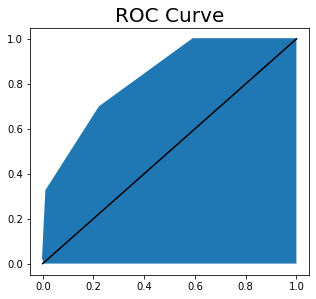

In [49]:
y_hat = best_model.predict(my_models.X_test)

fpr, tpr, _ = roc_curve(my_models.y_test, probs)

plt.figure(figsize=(5, 10))
plt.subplot(211)
plt.title('ROC Curve', fontsize=20)
plt.plot(fpr,tpr)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), color='black')
plt.fill_between(fpr,tpr)
plt.show();

In [50]:
cm = confusion_matrix(my_models.y_test, y_hat)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

print('True Positive = {}'.format(TP))
print('False Positive = {}'.format(FP))
print('False Negative = {}'.format(FN))
print('True Negative = {}'.format(TN))
print('\n{}% sensitivity, recall, or true positive rate =  TP/(TP+FN)'
      .format(100*round(TP/(TP+FN),2)))
print('{}% precision or positive predictive value = TP/(TP+FP)'
      .format(100*round(TP/(TP+FP),2)))

True Positive = 75
False Positive = 1
False Negative = 29
True Negative = 14

72.0% sensitivity, recall, or true positive rate =  TP/(TP+FN)
99.0% precision or positive predictive value = TP/(TP+FP)


A higher recall was expected, missing 25% of big earthqueake is quite high

SHAP: 
* http://www.f1-predictor.com/model-interpretability-with-shap/

* https://github.com/slundberg/shap

## 2.4. Regression

In [51]:
mag_ym.to_csv("./data/mag_ym.csv")

In [52]:
mag_ym[:540]

,mag
YM,
1970-01-01,5.815464
1970-02-01,5.815464
1970-03-01,6.000000
1970-04-01,5.815464
1970-05-01,5.815464
1970-06-01,7.000000
1970-07-01,5.815464
1970-08-01,5.815464
1970-09-01,5.700000


In [53]:
X_original = pd.DataFrame(mag_ym.index.astype('int'))
y_original = mag_ym['mag']


X_train = X_original[:540]
y_train = y_original[:540]
X_test  = X_original[540:]
y_test  = y_original[540:]

### Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)
forecastl = reg.predict(X_test)

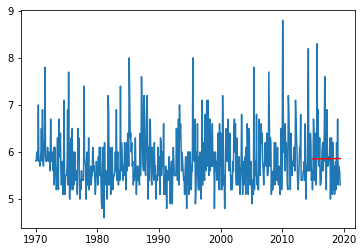

In [55]:
plt.plot(mag_ym)
plt.plot(mag_ym.index[540:],forecastl, color='r')

### K nearest neighbors

In [56]:
from sklearn.neighbors import KNeighborsRegressor
regk = KNeighborsRegressor(n_neighbors=10)
regk.fit(X_train,y_train)
forecastk = regk.predict(X_test)

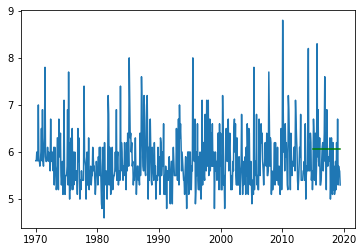

In [57]:
plt.plot(mag_ym)
plt.plot(mag_ym.index[540:],forecastk, color='g')

### Decision Tree
Max_depth: Number of Splits
Min_samples_leaf: Minimum number of observations per leaf

In [58]:
from sklearn.tree import DecisionTreeRegressor
regd = DecisionTreeRegressor(max_depth=3)
regd.fit(X_train,y_train)
forecastdt = regd.predict(X_test)

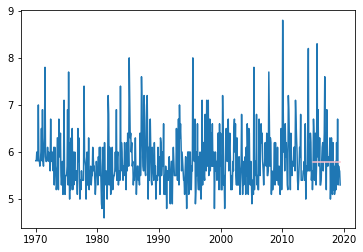

In [59]:
plt.plot(mag_ym)
plt.plot(mag_ym.index[540:],forecastdt, color='pink')

### Random Forest
n_estimators #tree
max_depth max #Splits
min_samples_leaf min #observations per leaf

In [60]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 40, max_depth = 12, min_samples_leaf = 50)
regr.fit(X_train,y_train)
forecastrf = regr.predict(X_test)

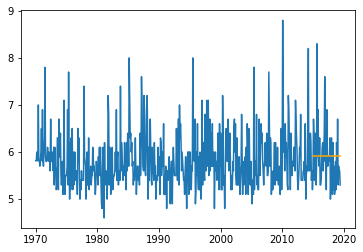

In [61]:
plt.plot(mag_ym)
plt.plot(mag_ym.index[540:],forecastrf, color='orange')

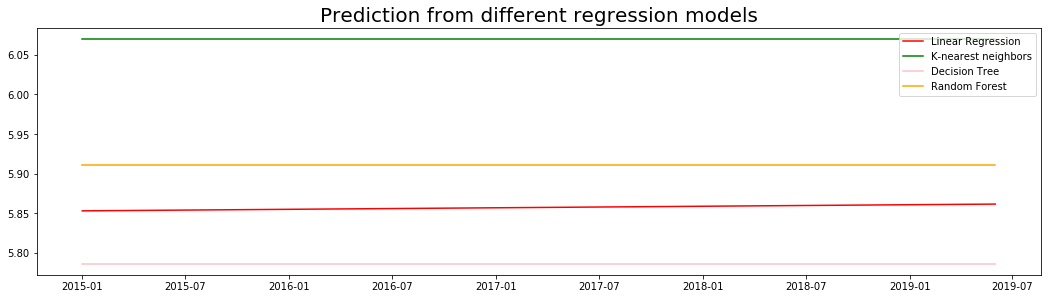

In [62]:
print('\n')
plt.figure(figsize=(18, 10))
plt.subplot(211)
plt.title('Prediction from different regression models', fontsize=20)
plt.plot(mag_ym.index[540:],forecastl, color='r', label='Linear Regression')
plt.plot(mag_ym.index[540:],forecastk, color='g', label='K-nearest neighbors')
plt.plot(mag_ym.index[540:],forecastdt, color='pink', label='Decision Tree')
plt.plot(mag_ym.index[540:],forecastrf, color='orange', label='Random Forest')
plt.legend(loc='best')
plt.show;